In [1]:
from Bio.PDB import PDBParser
import networkx as nx

class Protein:
    def __init__(self, fileName, thresh):
        self.pdbFile = fileName
        self.eThresh = thresh
        self.struct = self.getStruct(self.pdbFile)
        self.graph, self.layers = \
            self.genGraph(self.struct, self.eThresh)
        
    def getStruct(self, pdbFile):
        parser = PDBParser(QUIET=True)
        structure = \
            parser.get_structure("protein", pdbFile)
        return(structure)
        
    def genGraph(self, structure, eThresh):
        nodes, layers = [], []
        for model in structure:
            for chain in model:
                atoms = []
                for residue in chain:
                    for atom in residue:
                        if atom.name=="CA":
                            atoms.append(atom)
                if len(atoms):
                    nodes.extend(atoms)
                    layers.append(len(atoms))
        edges = []
        for i in range(len(nodes)-1):
            for j in range(i+1, len(nodes)):
                dist = nodes[i]-nodes[j]
                if dist>0. and dist<=eThresh:
                    edges.append((i,j))
        g = nx.Graph(edges)
        return(g, layers)

    def getGraph(self):
        return(self.graph, self.layers)

In [2]:
import numpy as np

class MultiCens:
    # implementation based on original MultiCens
    def __init__(self, g, layers, p, nIter):
        self.nodes = list(g.nodes())
        self.nodes.sort()
        self.edges = list(g.edges())
        self.layers = layers
        self.p = p
        self.nIter = nIter
        self.a, self.c = \
            self.getAdjMat(self.edges, self.layers)
        self.gc = self.computeGlobal()

    def getAdjMat(self, edges, layers):
        l1, l2 = layers[0], layers[1]
        adj = np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            adj[u, v] = 1.
            adj[v, u] = 1.
        adj = adj / np.sum(adj, axis=0)
        a, c = np.zeros(shape=(l1+l2, l1+l2)), \
                        np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            if (u<l1 and v<l1) or (u>=l1 and v>=l1):
                a[u, v] = adj[u, v]
                a[v, u] = adj[v, u]
            elif (u<l1 and l1>=l1) or (v<l1 and u>=l1):
                c[u, v] = adj[u, v]
                c[v, u] = adj[v, u]
        return(a, c)
    
    def unitVector(self, vector):
        return(vector/np.linalg.norm(vector))
    
    def angleBetween(self, v1, v2):
        v1_u = self.unitVector(v1)
        v2_u = self.unitVector(v2)
        return(np.arccos(np.clip( \
                np.dot(v1_u, v2_u), -1.0, 1.0)))
    
    def computeLocal(self):
        n = self.a.shape[0]
        l = np.ones(n) / n
        unitNormal = np.copy(l)
        angle = float(0)
        for _ in range(self.nIter):
            lNew = (self.p*(self.a.dot(l))) + \
                            ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(l, lNew)
            if (angleNew==angle) or (angleNew==0):
                break
            l, angle = lNew, angleNew
        return(l)
    
    def computeGlobal(self):
        l = self.computeLocal()
        n = self.a.shape[0]
        g = np.ones(n) / n
        unitNormal = np.copy(g)
        angle = float(0)
        for _ in range(self.nIter):
            gNew = (self.p*((self.a+self.c).dot(g) + \
                self.c.dot(l))) + ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(g, gNew)
            if (angleNew==angle) or (angleNew==0):
                break
            g, angle = gNew, angleNew
        return(g)

    def getMultiCens(self):
        mc = (self.gc-self.gc.min()) /  \
                       (self.gc.max()-self.gc.min())
        mc = {x:mc[x] for x in self.nodes}
        return(mc)

In [657]:
# from networkx.algorithms import community
# from pulp import LpProblem, LpVariable, lpSum, LpMinimize
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import MinMaxScaler
# rng = np.random.RandomState(42)

# class MultiLayerCentrality:
#     def __init__(self, g, layers, k):
#         self.g = g
#         self.nodes = list(g.nodes())
#         self.nodes.sort()
#         self.k = k
#         self.layer1 = [i for i in range(layers[0])]
#         self.layer2 = [i for i in range(layers[0],layers[0]+layers[1])]
#         self.l1, self.l2 = layers[0], layers[1]
#         print(self.l1, self.l2)
#         self.l1g = g.subgraph(self.layer1)
#         self.l2g = g.subgraph(self.layer2)
#         # print(list(self.l1g.nodes))
#         # print(list(self.l2g.nodes))
#         self.scores = self.computeMLC()
    
#     def compute_khop_jaccard_matrix(self, graph, k):
#         n = graph.number_of_nodes()
#         nodes = list(graph.nodes)
#         nodes.sort()
#         # print(nodes)
#         # node_index = {node: idx for idx, node in enumerate(nodes)}  # Mapping of nodes to indices
#         # Step 1: Compute k-hop neighbors for all nodes
#         khop_neighbors = {}
#         for node in nodes:
#             neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=k)
#             # print(neighbors)
#             # for x in graph.neighbors(354): print(x)
#             khop_neighbors[node] = set(neighbors.keys()) - {node}
#             # print(khop_neighbors[node])
#             # break
#         # print(khop_neighbors)
#         # Step 2: Initialize similarity matrix
#         jaccard_matrix = np.zeros((n, n))
#         # Step 3: Compute pairwise Jaccard similarity
#         for i, u in enumerate(nodes):
#             for j, v in enumerate(nodes):
#                 if i <= j:  # Compute for upper triangular matrix
#                     nu, nv = khop_neighbors[u], khop_neighbors[v]
#                     intersection = len(nu & nv)
#                     union = len(nu | nv)
#                     similarity = intersection / union if union > 0 else 0.0
#                     jaccard_matrix[i, j] = jaccard_matrix[j, i] = similarity
#         # print(jaccard_matrix[:10])
#         return jaccard_matrix

#     def scale(self, Y):
#         # Ensure Y is a dense numpy array
#         # Y = np.array(Y)
#         # Exclude diagonal elements
#         Y_no_diag = Y.copy()
#         np.fill_diagonal(Y_no_diag, 0)
#         # Row-wise min-max normalization
#         # min_vals = np.min(Y_no_diag, axis=1, keepdims=True)
#         # max_vals = np.max(Y_no_diag, axis=1, keepdims=True)
#         # delta = max_vals - min_vals
#         # # Handle rows where min == max (all values are identical)
#         # delta[delta == 0] = 1
#         # Y_rescaled = (Y_no_diag - min_vals) / delta
#         # Normalize by the maximum row sum
#         row_sums = np.sum(Y_no_diag, axis=1, keepdims=True)
#         max_row_sum = np.max(row_sums)
#         Y_normalized = Y_no_diag / max_row_sum
#         return Y_normalized
    

#     def computeMLC(self):
#         # l1g = self.l1g.copy()
#         # communities = community.greedy_modularity_communities(l1g)
#         # community_sets = [set(community) for community in communities]
#         # for u, v in list(l1g.edges()):
#         #     if not any(u in comm and v in comm for comm in community_sets):
#         #         l1g.remove_edge(u, v)
#         # self.l1g = l1g

#         # l2g = self.l2g.copy()
#         # communities = community.greedy_modularity_communities(l2g)
#         # community_sets = [set(community) for community in communities]
#         # for u, v in list(l2g.edges()):
#         #     if not any(u in comm and v in comm for comm in community_sets):
#         #         l2g.remove_edge(u, v)
#         # self.l2g = l2g

#         # def minimum_dominating_set(G):
#         #     print(list(G.nodes()))
#         #     prob = LpProblem("Minimum Dominating Set", LpMinimize)
#         #     x = {v: LpVariable(f"x_{v}", cat="Binary") for v in G.nodes}
        
#         #     # Objective: Minimize the number of selected nodes
#         #     prob += lpSum(x[v] for v in G.nodes)
        
#         #     # Constraints: Each node must be dominated
#         #     for v in G.nodes:
#         #         prob += x[v] + lpSum(x[u] for u in G.neighbors(v)) >= 1
        
#         #     prob.solve()
        
#         #     return {v for v in G.nodes if x[v].varValue == 1}
            
#         # def remove_internal_edges(G, dominating_set):
#         #     G = G.copy()  # Work on a copy to avoid modifying the original graph
#         #     internal_edges = [(u, v) for u, v in G.edges if u in dominating_set or v in dominating_set]
#         #     G.remove_edges_from(internal_edges)
#         #     return G
        
        
#         # min_dom_set = minimum_dominating_set(self.l1g)
#         # print(min_dom_set)
#         # self.l1g = remove_internal_edges(self.l1g, min_dom_set)
#         # min_dom_set = minimum_dominating_set(self.l2g)
#         # print(min_dom_set)
#         # self.l2g = remove_internal_edges(self.l2g, min_dom_set)
        
                
#         # overlapl1 = self.compute_khop_jaccard_matrix(self.l1g, self.k)
#         # overlapl2 = self.compute_khop_jaccard_matrix(self.l2g, self.k)
#         # overlapg = self.compute_khop_jaccard_matrix(self.g, self.k)
        
#         # W = np.zeros((self.l1+self.l2, self.l1+self.l2))
#         # W[:self.l1, :self.l1] = self.scale(overlapl1)
#         # W[self.l1:, self.l1:] = self.scale(overlapl2)
#         # X = self.scale(overlapg)
#         # # W = standardize(W)
#         # # X = standardize(X)
#         # #WA = X
#         # A = rng.randn(self.l1+self.l2, self.l1+self.l2)
#         # learning_rate = 0.01
#         # iterations = 1000
#         # lambda_reg = 0.01  
#         # for i in range(iterations):
#         #     grad = 2 * W.T @ (W @ A - X) + 2 * lambda_reg * A
#         #     A -= learning_rate * grad
            
#         # node_scores = np.sum(np.dot(W, A), axis=1)

             
#         betweenness_layer1 = nx.betweenness_centrality(self.l1g)
#         betweenness_layer2 = nx.betweenness_centrality(self.l2g)
#         degree_centrality_combined = nx.degree_centrality(self.g)
#         nodes = list(self.g.nodes())
#         nodes.sort()
#         # Convert to numpy arrays
#         betweenness_layer1_values = np.array([betweenness_layer1.get(n, 0) for n in nodes]).reshape(-1, 1)
#         betweenness_layer2_values = np.array([betweenness_layer2.get(n, 0) for n in nodes]).reshape(-1, 1)
#         degree_values = np.array([degree_centrality_combined[n] for n in nodes]).reshape(-1, 1)
        
#         # Normalize betweenness and degree centralities
#         scaler = MinMaxScaler()
#         betweenness_layer1_scaled = scaler.fit_transform(betweenness_layer1_values).flatten()
#         betweenness_layer2_scaled = scaler.fit_transform(betweenness_layer2_values).flatten()
#         degree_scaled = scaler.fit_transform(degree_values).flatten()

#         alpha, beta, gamma = 0.5, 0.5, 0.3  # Reduce gamma if degree is dominating
#         merged_betweenness = {
#             nodes[i]: (betweenness_layer1_scaled[i] ** alpha) *
#                       (betweenness_layer2_scaled[i] ** beta) *
#                       (degree_scaled[i] ** gamma)
#             for i in range(len(nodes))
#         }
#         # Sort nodes by final merged ranking
#         # ranked_nodes = sorted(merged_betweenness.items(), key=lambda x: x[1], reverse=True)
        
#         # # Compute betweenness centrality for the entire graph
#         # betweenness_full_graph = nx.betweenness_centrality(self.g, normalized=True)
        
#         # # Combine layer 1 and layer 2 betweenness into a combined feature vector
#         # combined_betweenness = []
#         # for node in sorted(self.l1g.nodes()):
#         #     combined_betweenness.append(betweenness_layer1[node])
#         # for node in sorted(self.l2g.nodes()):
#         #     combined_betweenness.append(betweenness_layer2[node])
        
#         # combined_betweenness = np.array(combined_betweenness)
        
#         # # Corresponding full graph betweenness (target variable)
#         # full_graph_betweenness = np.array([betweenness_full_graph[node] for node in sorted(self.g.nodes())])
        
#         # # Train a regression model (e.g., Linear Regression)
#         # model = LinearRegression()
#         # print(combined_betweenness.shape, full_graph_betweenness.shape)
#         # combined_betweenness = combined_betweenness.reshape(-1,1)
#         # model.fit(combined_betweenness, full_graph_betweenness)
        
#         # # Predict the full graph betweenness from combined layers
#         # node_scores = model.predict(combined_betweenness)
        
#         return(merged_betweenness)

#     def getMLC(self):
#         mlc = np.array([self.scores[i] for i in range(self.l1+self.l2)])
#         mlc = (mlc-mlc.min()) / (mlc.max()-mlc.min())
#         mlc = {x:mlc[x] for x in self.nodes}
#         return(mlc)


Over


In [3]:
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx
from networkx.algorithms.community import greedy_modularity_communities
import random
seed = 42
torch.manual_seed(seed)       # PyTorch
random.seed(seed)             # Python's random module
np.random.seed(seed)  

class NodeRankingGNN(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super(NodeRankingGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, 1)  # Output ranking score

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x  # No sigmoid to keep ranking raw

class CentralityMetric:
    def __init__(self, g, layer1, layer2):
        self.G = g  # Replace with your actual graph
        self.g1 = layer1
        self.g2 = layer2
        self.nodes = list(self.G.nodes())
        # self.nodes.sort()
    
        # Ensure the graph is directed
        if not self.G.is_directed():
            print("Converting to a directed graph.")
            self.G = nx.DiGraph(self.G)
        
        # Use the largest weakly connected component
        if not nx.is_weakly_connected(self.G):
            print("Graph is not weakly connected. Using the largest weakly connected component.")
            self.largest_component = max(nx.weakly_connected_components(self.G), key=len)
            self.G = self.G.subgraph(self.largest_component).copy()
        
        # Choose a source node with the highest out-degree
        self.source = max(self.nodes, key=lambda n: self.G.out_degree(n))
        print(f"Source node: {source} (Out-degree: {self.G.out_degree(source)})")

    def compMLModularity(self, g, layer1, layer2, gamma=1, omega=1):
        layer1 = [x for x in layer1.nodes()]
        layer1.sort()
        layer2 = [x for x in layer2.nodes()]
        layer2.sort()
        # a = self.a+self.c
        a = nx.adjacency_matrix(g).todense()
        m = a.sum() / 2  
        commu = list(greedy_modularity_communities(g))
        commuMap = {node: i for i,com in enumerate(commu) for node in com}
        mod = {i: 0 for i in range(len(a))}  
    
        for i in range(len(a)):
            for j in range(len(a)):
                same = commuMap[i] == commuMap[j]
                intra = (i in layer1 and j in layer1) or (i in layer2 and j in layer2)
                inter = (i in layer1 and j in layer2) or (i in layer2 and j in layer1)
                ki = a[i].sum()
                kj = a[j].sum()
        
                if intra:
                    contrib = (a[i, j] - gamma * (ki * kj / (2 * m))) * same
                    mod[i] += contrib  
                    mod[j] += contrib  
        
                elif inter:
                    contrib = omega * a[i, j] * same
                    mod[i] += contrib  
                    mod[j] += contrib  
        
        return(mod)

    def compute(self):
        k_core = nx.core_number(self.G)
        core_values = list(k_core.values())
        min_core = min(core_values)
        max_core = max(core_values)
        normalized_k_core = {node: (core - min_core) / (max_core - min_core) for node, core in k_core.items()}
        # normalized_k_core = [normalized_k_core[x] for x in self.nodes]
        
        degree_centrality = nx.degree_centrality(self.G)
        values = list(degree_centrality.values())
        min_val = min(values)
        max_val = max(values)
        degree_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in degree_centrality.items()}
        
        closeness_centrality = nx.closeness_centrality(self.G)
        values = list(closeness_centrality.values())
        min_val = min(values)
        max_val = max(values)
        closeness_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in closeness_centrality.items()}
        
        eigenvector_centrality = nx.eigenvector_centrality_numpy(self.G)
        values = list(eigenvector_centrality.values())
        min_val = min(values)
        max_val = max(values)
        eigenvector_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in eigenvector_centrality.items()}
        
        betweenness_centrality = nx.betweenness_centrality(self.G)
        values = list(betweenness_centrality.values())
        min_val = min(values)
        max_val = max(values)
        betweenness_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in betweenness_centrality.items()}
        
        # pagerank = nx.pagerank(G)
        # values = list(pagerank.values())
        # min_val = min(values)
        # max_val = max(values)
        # pagerank = {key: (value - min_val) / (max_val - min_val) for key, value in pagerank.items()}
        
        # clustering_coeff = nx.clustering(G.to_undirected())
        # values = list(clustering_coeff.values())
        # min_val = min(values)
        # max_val = max(values)
        # clustering_coeff = {key: (value - min_val) / (max_val - min_val) for key, value in clustering_coeff.items()}
        
        l3_metric = self.compute_l3_triangle_metric(self.G)
        values = list(l3_metric.values())
        min_val = min(values)
        max_val = max(values)
        l3_metric = {key: (value - min_val) / (max_val - min_val) for key, value in l3_metric.items()}

        mod_score = self.compMLModularity(self.G, self.g1, self.g2)
        values = list(mod_score.values())
        min_val = min(values)
        max_val = max(values)
        mod_score = {key: (value - min_val) / (max_val - min_val) for key, value in mod_score.items()}
        
        
        immediate_dominators = nx.immediate_dominators(self.G, self.source)
        # Compute transitive dominator influence
        dominator_count = {node: 0 for node in self.nodes}
        for node in self.nodes:
            if node in immediate_dominators:
                dom = immediate_dominators[node]
                if dom in dominator_count:
                    dominator_count[dom] += 1
        
        # Fix: Compute transitive closure of domination
        for node in self.nodes:
            dominated_set = set()
            stack = [node]
            while stack:
                current = stack.pop()
                if current in immediate_dominators and current != source:
                    parent = immediate_dominators[current]
                    if parent not in dominated_set:
                        dominated_set.add(parent)
                        stack.append(parent)
            
            # The number of nodes dominated (excluding itself)
            dominator_count[node] = len(dominated_set)
        dominator_weight = {node: dominator_count[node] for node in self.nodes}  # Bias higher for dominators
        dominator_centrality = nx.pagerank(self.G, personalization=dominator_weight)
        kcore_weight = {node: normalized_k_core[node] for node in self.nodes}  # Bias higher for dominators
        kcore = nx.pagerank(self.G, personalization=kcore_weight)
        btw_weight = {node: betweenness_centrality[node] for node in self.nodes}  # Bias higher for dominators
        btw = nx.pagerank(self.G, personalization=btw_weight)
        l3_weight = {node: l3_metric[node] for node in self.nodes}  # Bias higher for dominators
        l3 = nx.pagerank(self.G, personalization=l3_weight)
        deg_weight = {node: degree_centrality[node] for node in self.nodes}  # Bias higher for dominators
        deg = nx.pagerank(self.G, personalization=deg_weight)
        mc_weight = {node: m[node] for node in self.nodes}  # Bias higher for dominators
        mc = nx.pagerank(self.G, personalization=mc_weight)
        mod_weight = {node: mod_score[node] for node in self.nodes}  # Bias higher for dominators
        mod = nx.pagerank(self.G, personalization=mod_weight)
        
        # print(dominator_centrality)
        
        
        # --- Step 3: Convert Features to PyTorch Tensor ---
        # nodes = list(G.nodes())  # Maintain order
        
        node_features = []
        for node in self.nodes:
            node_features.append([
                degree_centrality[node],
                # closeness_centrality[node],
                # betweenness_centrality[node],
                # eigenvector_centrality[node],
                # pagerank[node],
                # clustering_coeff[node],
                mod[node],
                deg[node],
                l3[node],
                dominator_centrality[node],  # Add dominator centrality as a feature
                kcore[node]
                # btw[node],
                # mc[node]
            ])
        
        node_features = torch.tensor(node_features, dtype=torch.float32)
        
        # Convert to PyG format
        data = from_networkx(self.G)
        data.x = node_features  # Assign node features
        
        # Create a node-to-index mapping
        node_to_index = {node: i for i, node in enumerate(self.nodes)}

        wt = []
        for node in sorted(node_to_index.keys()):
            wt.append(dominator_weight[node])
        wt = torch.tensor(wt)
        # Initialize Model
        model = NodeRankingGNN(in_features=node_features.shape[1], hidden_dim=16)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            rankings = model(data.x, data.edge_index).squeeze()
            transmission = self.refined_transmission(self.G, rankings, dominator_centrality)
            loss = -torch.sum(transmission) + self.ranking_loss(rankings, data.edge_index)
            # loss = -torch.sum(transmission) + self.ranking_loss(rankings, data.edge_index, wt)
            loss.backward()
            optimizer.step()
            # print(f"Epoch {epoch+1}: Loss = {loss.item()}")
        model.eval()
        with torch.no_grad():
            rankings = model(data.x, data.edge_index).squeeze()
        rankings = (rankings - rankings.mean()) / rankings.std()
        rankings_np = rankings.cpu().numpy()
        
        metric = []
        d, c, e, b = [], [], [], []
        # print("Node Rankings:")
        for node in sorted(node_to_index.keys()):
            # print(f"Node {node}: Score = {rankings_np[node_to_index[node]]:.4f}")
            metric.append(rankings_np[node_to_index[node]])
            d.append(degree_centrality[node_to_index[node]])
            c.append(closeness_centrality[node_to_index[node]])
            e.append(eigenvector_centrality[node_to_index[node]])
            b.append(betweenness_centrality[node_to_index[node]])
            
        
        metric = np.array(metric)
        metric = (metric - metric.min()) / (metric.max() - metric.min())
        # print(metric)
        return(d, c, e, b,metric)
    
    # --- Step 5: Refined Transmission Model ---
    def refined_transmission(self, G, rankings, dom_centrality, alpha=0.5, beta=0.5, num_steps=3):
        num_nodes = rankings.shape[0]
        transmission = torch.zeros_like(rankings)
        edge_index = torch.tensor(list(G.edges()), dtype=torch.long, device=rankings.device)
        weights = torch.tensor([G[u][v].get('weight', 1.0) for u, v in G.edges()],
                               dtype=torch.float32, device=rankings.device)
        dom_centrality_tensor = torch.tensor([dom_centrality[node] for node in self.nodes], 
                                             dtype=torch.float32, device=rankings.device)
        for _ in range(num_steps):
            temp_transmission = torch.zeros_like(rankings)
            influence = weights * F.sigmoid(rankings[edge_index[:, 0]]) * dom_centrality_tensor[edge_index[:, 0]]
    
            temp_transmission.index_add_(0, edge_index[:, 1], influence)
    
            # Apply decay and update transmission
            transmission = beta * transmission + alpha * temp_transmission
    
        return transmission
    
    def ranking_loss(self, scores, edge_index):
        src, dst = edge_index
        diff = scores[src] - scores[dst]  # Encourage src > dst
        return torch.mean(torch.relu(1 - diff))  # Hinge loss

    # def ranking_loss(self, scores, edge_index, weights, margin=1.0, lambda_contrast=0.1, lambda_smooth=0.05):
    #     src, dst = edge_index
    
    #     # Adaptive margin based on node centralities (degree-aware margin example)
    #     margin_uv = torch.log1p(weights[src]) / torch.log1p(weights[dst])
        
    #     # Hinge loss with adaptive margin
    #     loss_rank = torch.mean(torch.relu(margin_uv - (scores[src] - scores[dst])))
    
    #     # Contrastive separation loss
    #     loss_contrast = torch.mean(torch.relu(margin - torch.abs(scores[src] - scores[dst])))
    
    #     # Graph-aware smoothness loss
    #     loss_smooth = torch.mean(weights * (scores[src] - scores[dst]) ** 2)
    
    #     return loss_rank + lambda_contrast * loss_contrast + lambda_smooth * loss_smooth

    
    def compute_l3_triangle_metric(self, G):
        l3_triangle_metric = {}
    
        for node in self.nodes:
            # Find all 2-hop neighbors
            neighbors = set(G.neighbors(node))
            # Get all 3-hop neighbors
            three_hop_neighbors = set()
    
            for neighbor in neighbors:
                three_hop_neighbors.update(G.neighbors(neighbor))
    
            # Count triangles involving the node and its 2-hop and 3-hop neighbors
            triangle_count = 0
            for three_hop_neighbor in three_hop_neighbors:
                if node in G.neighbors(three_hop_neighbor):
                    triangle_count += 1
    
            l3_triangle_metric[node] = triangle_count
    
        return l3_triangle_metric
    





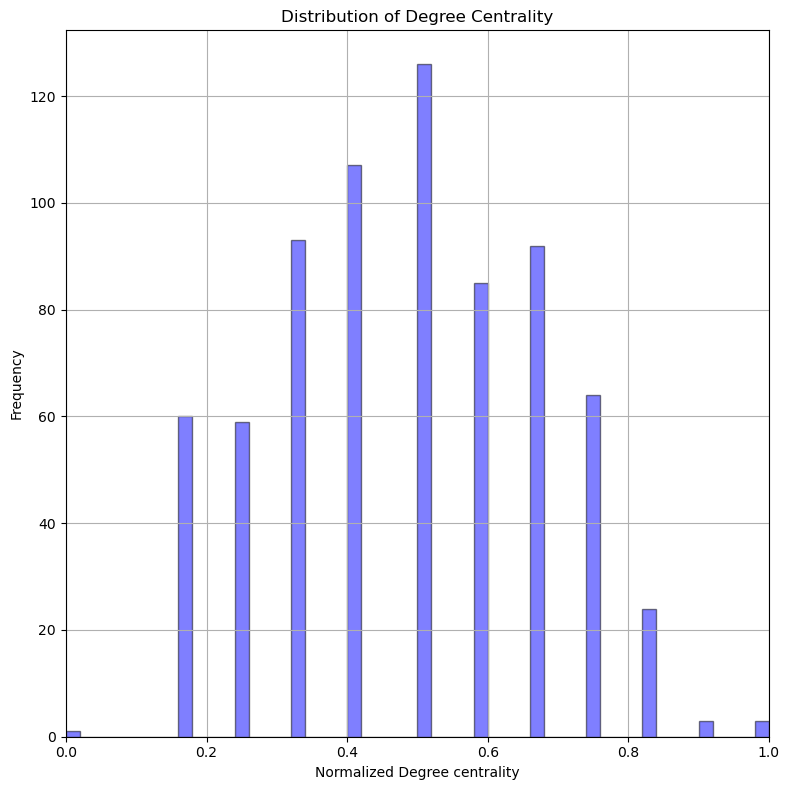

In [495]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_distribution(c, t, xl, yl):
    plt.figure(figsize=(8, 8))
    plt.hist(c, color='blue', bins=50, fill=True, alpha=0.5, edgecolor='black')
    plt.title(t)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.grid()
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

plot_distribution(d, "Distribution of Degree Centrality", "Normalized Degree centrality", "Frequency")

In [1043]:
import numpy as np
import pandas as pd
np.random.seed(42)
import os

centrality_data = []
directory = "data/"
index = 0
graphs = []
for fn in os.listdir(directory):
    
    filename = directory+fn
    prot = Protein(filename,7.)
    # prot = Protein("data/fold_sim2_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_sim1_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas4_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas3_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas2_bmal1_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas1_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_hif3a_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_hif2a_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_hif1a_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_clock_bmal1_model_0.pdb", 7.)
    # prot = Protein("data/fold_ahr_arnt_model_0.pdb", 7.)

    g, layers = prot.getGraph()
    graphs.append(g)
    l1, l2 = layers[0], layers[1]
    
    mc = MultiCens(g, layers, .9, 1000)
    m = mc.getMultiCens()
    m = np.array([m[i] for i in range(l1+l2)])


    layer1 = [x for x in range(layers[0])]
    layer2 = [x for x in range(layers[0], layers[0]+layers[1])]
    g1 = g.subgraph(layer1)
    g2 = g.subgraph(layer2)

    cm = CentralityMetric(g, g1, g2)
    d,c,e,b,metric = cm.compute()

    for n in range(len(m)):
        row = {
            "graph": f"graph{index}",
            "node": n,
            "degree": d[n],
            "closeness": c[n],
            "betweenness": b[n],
            "eigenvector": e[n],
            "multicens": m[n],
            "new": metric[n],
        }
        centrality_data.append(row)
    index += 1
        
df = pd.DataFrame(centrality_data)
print("Over")

Converting to a directed graph.
Source node: 220 (Out-degree: 12)
Converting to a directed graph.
Source node: 220 (Out-degree: 5)
Converting to a directed graph.
Source node: 220 (Out-degree: 13)
Converting to a directed graph.
Source node: 220 (Out-degree: 7)
Converting to a directed graph.
Source node: 220 (Out-degree: 8)
Converting to a directed graph.
Source node: 220 (Out-degree: 5)
Converting to a directed graph.
Source node: 220 (Out-degree: 6)
Converting to a directed graph.
Source node: 220 (Out-degree: 5)
Converting to a directed graph.
Source node: 220 (Out-degree: 12)
Converting to a directed graph.
Source node: 220 (Out-degree: 8)
Converting to a directed graph.
Source node: 220 (Out-degree: 6)
Over


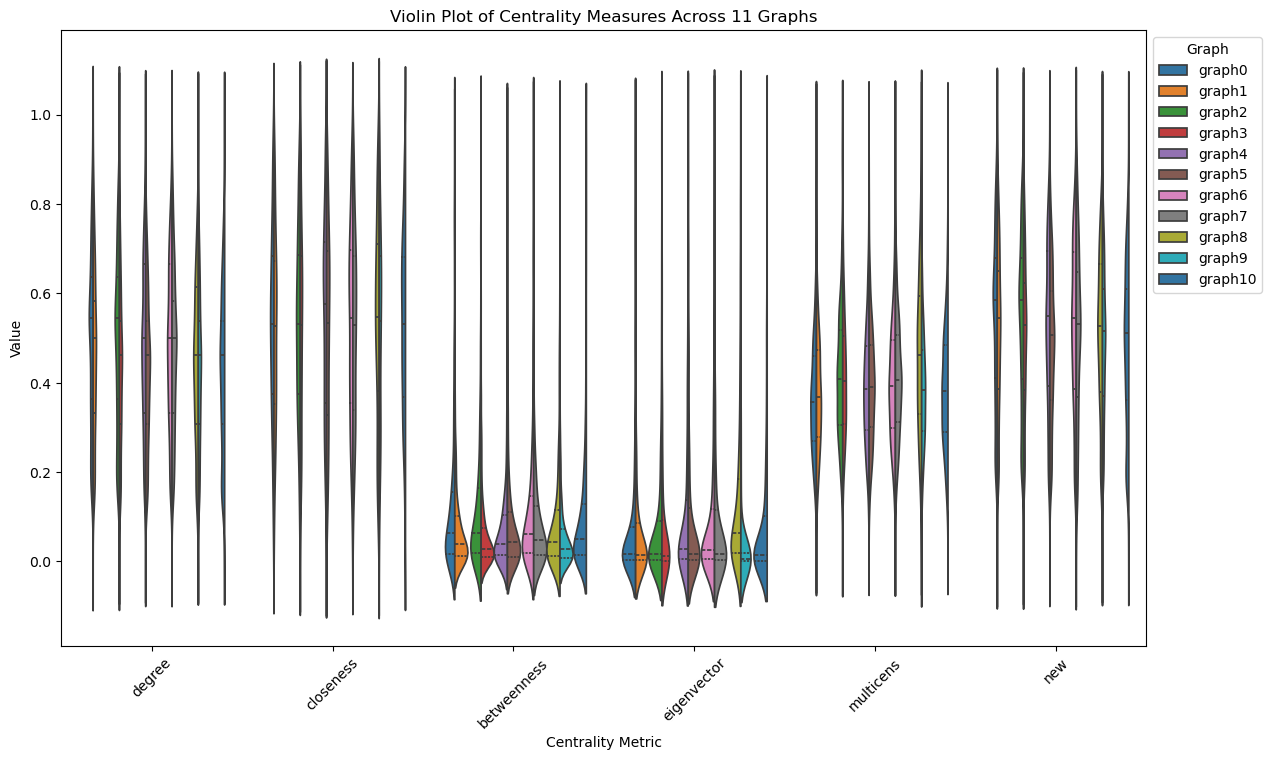

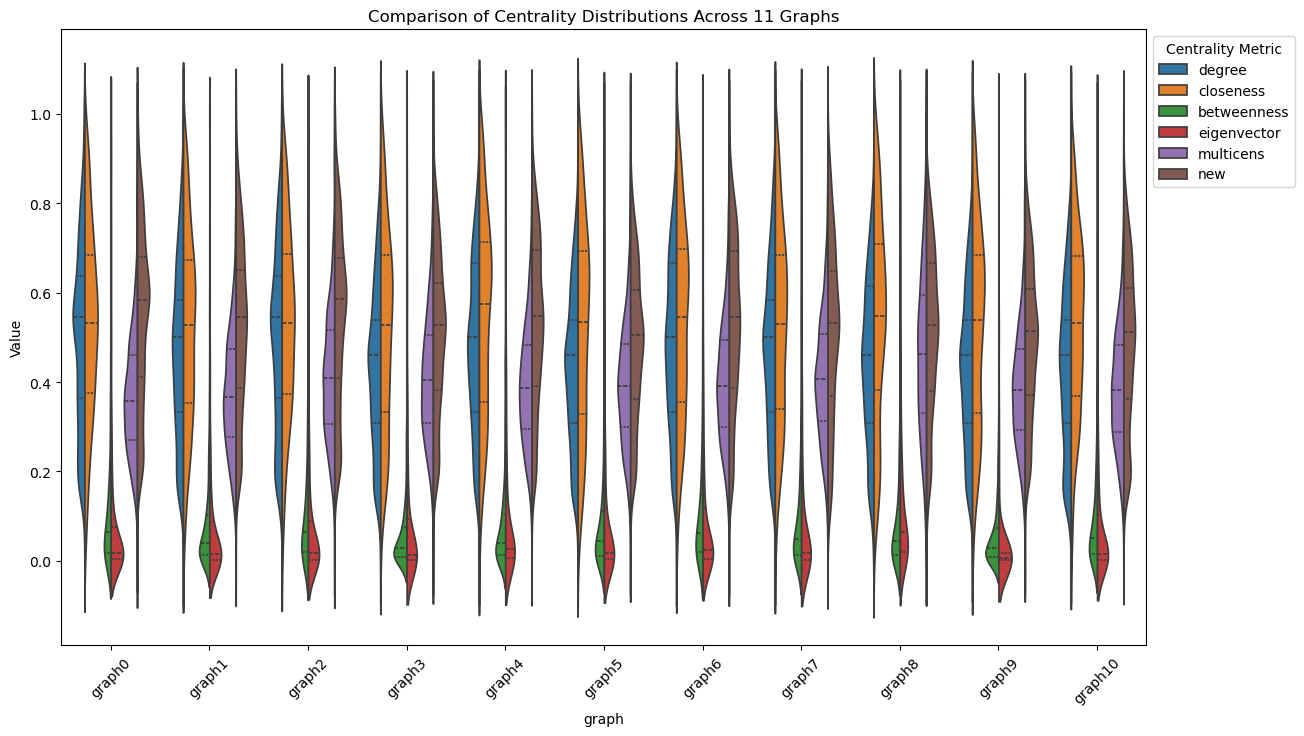

In [1022]:
df_melted = df.melt(id_vars=["graph", "node"], 
                     var_name="Centrality Metric", 
                     value_name="Value")

# Plot violin plots
plt.figure(figsize=(14, 8))
sns.violinplot(x="Centrality Metric", y="Value", hue="graph", data=df_melted, 
               split=True, inner="quartile", palette="tab10")

plt.xticks(rotation=45)
plt.title("Violin Plot of Centrality Measures Across 11 Graphs")
plt.legend(title="Graph", bbox_to_anchor=(1, 1))
plt.show()

df_melted = df.melt(id_vars=["graph", "node"], 
                     var_name="Centrality Metric", 
                     value_name="Value")

# Set figure size
plt.figure(figsize=(14, 8))

# Create violin plot
sns.violinplot(x="graph", y="Value", hue="Centrality Metric", 
               data=df_melted, split=True, inner="quartile", palette="tab10")

# Formatting
plt.xticks(rotation=45)
plt.title("Comparison of Centrality Distributions Across 11 Graphs")
plt.legend(title="Centrality Metric", bbox_to_anchor=(1, 1))
plt.show()

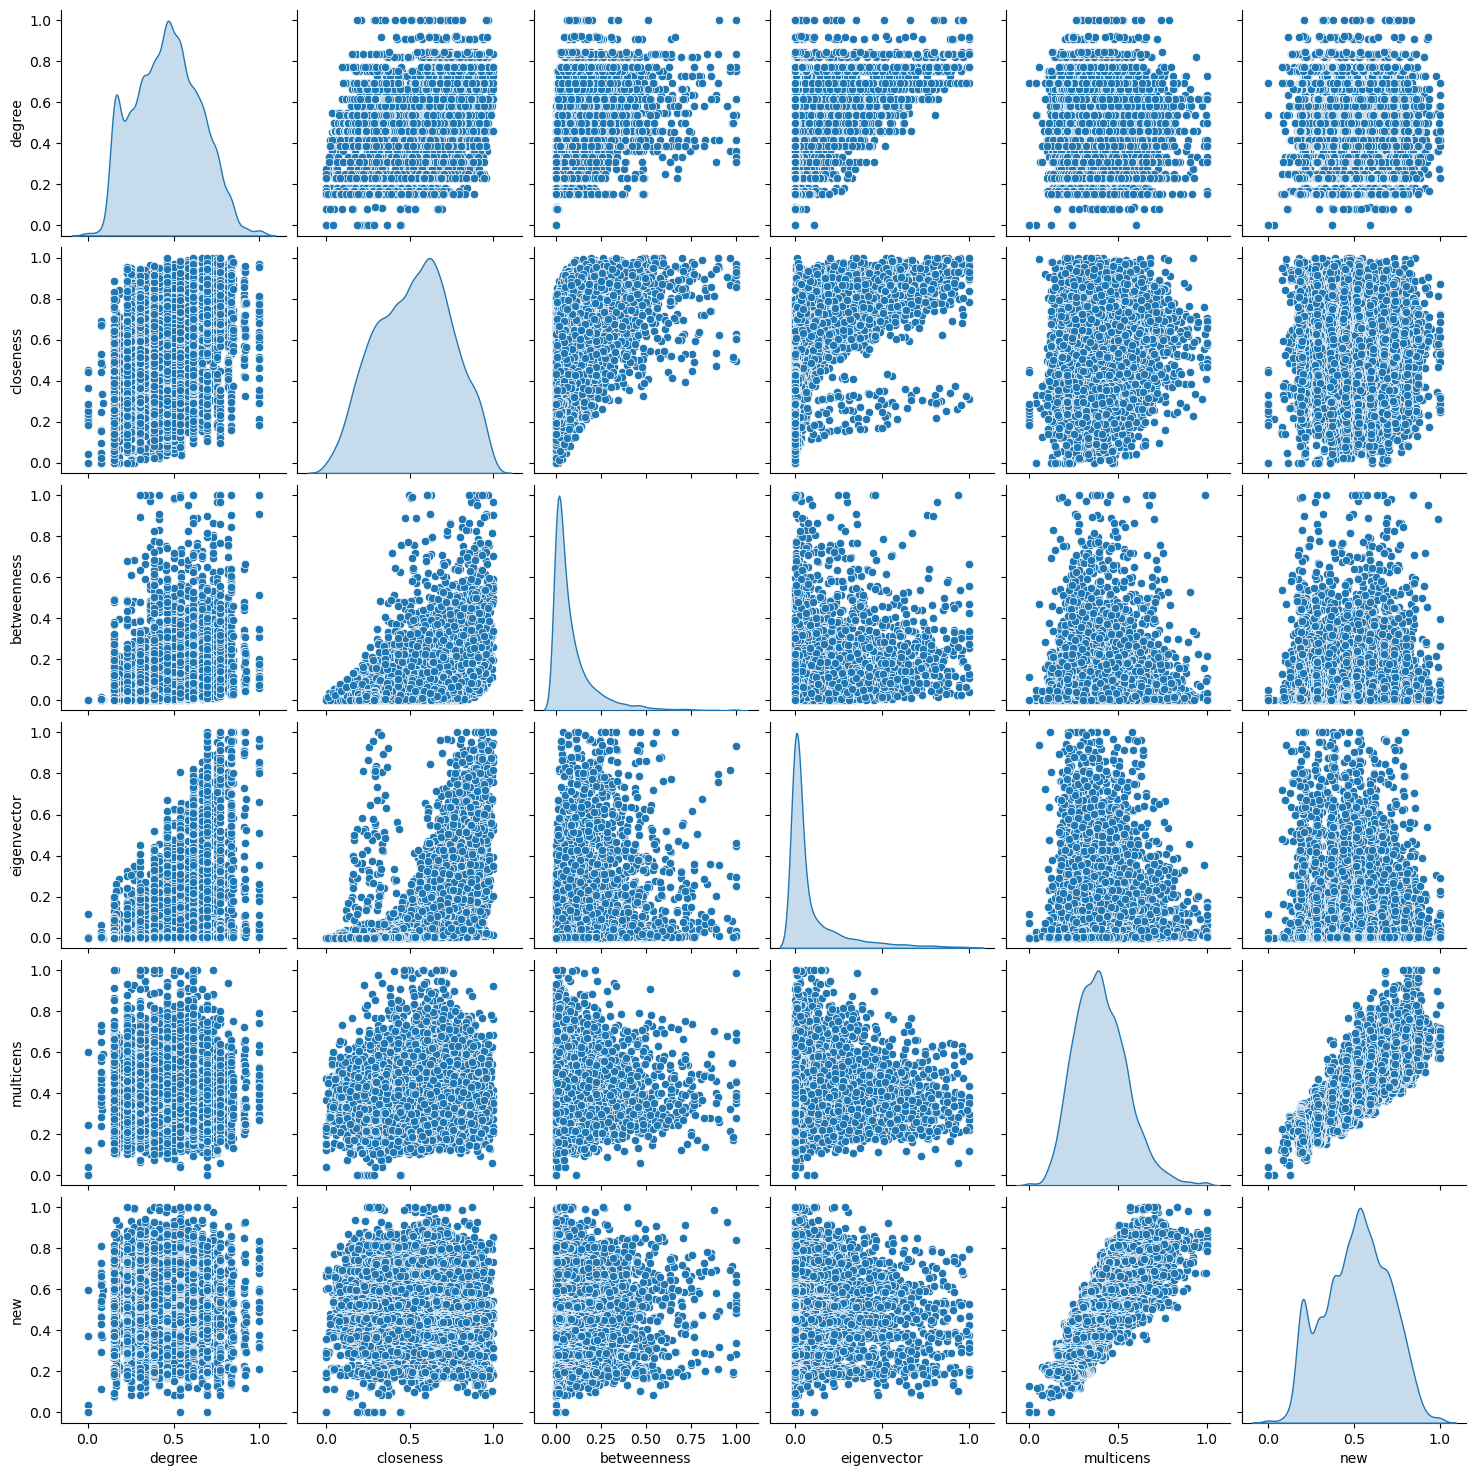

In [1021]:
sns.pairplot(df.drop(columns=["graph", "node"]), diag_kind="kde")
plt.show()

[713  74 396 121 630 197 528]
[170 163 372 570 138  64 164]
[175 371 163 139 584 372 567]
[152 240 676 270 326 279 164]
[ 80 421 559 560 183 386 223]
[623  94 436 240 630 161 559]


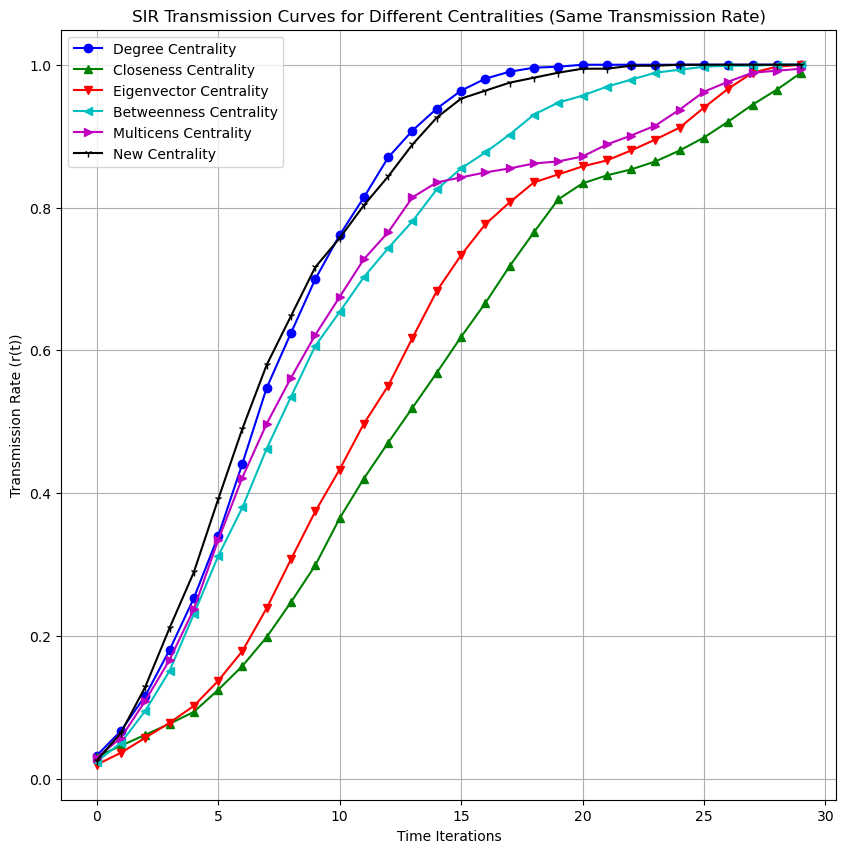

In [1045]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
            

def get_sorted_centrality(df, graph_name, centrality_col):
    graph_df = df[df["graph"] == graph_name]
    sorted_graph_df = graph_df.sort_values(by="node")
    sorted_centrality_values = sorted_graph_df[centrality_col].to_numpy()
    return sorted_centrality_values

graph_name = "graph7"  # Replace with the desired graph
centrality_col = "degree"  # Replace with the desired centrality metric
d = get_sorted_centrality(df, graph_name, centrality_col)
# print(d)
centrality_col = "closeness"  # Replace with the desired centrality metric
c = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "betweenness"  # Replace with the desired centrality metric
b = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "eigenvector"  # Replace with the desired centrality metric
e = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "multicens"  # Replace with the desired centrality metric
m = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "new"  # Replace with the desired centrality metric
n = get_sorted_centrality(df, graph_name, centrality_col)


seed = 42
np.random.seed(seed)
random.seed(seed)
rng = np.random.RandomState(seed)

# nodes = list(g.nodes())
# nodes.sort()

# Create a sample network (replace with your own graph)
# G = nx.erdos_renyi_graph(1000, 0.05)  # Example: 1000 nodes, 5% edge probability
G = graphs[7]
# Compute centrality measures (Degree, Betweenness, Closeness)
# degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)

degree_centrality = d
closeness_centrality = c
eigenvector_centrality = e
betweenness_centrality = b
multicens_centrality = m
multilayer_centrality = n
# print(normalized_scores)

# mlc = np.load('mlc.npy')


# Function to simulate SIR dynamics for a given centrality measure
def simulate_SIR(centrality, beta=0.2, gamma=0.1, time_steps=30):
    # sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    # top_1_percent_nodes = [node for node, _ in sorted_nodes[:int(0.01 * len(G))]]
    
    top_1_percent_count = int(0.01 * len(centrality))  # Calculate 1% of the total nodes
    top_1_percent_nodes = np.argsort(centrality)[::-1][:top_1_percent_count]  # Get indices of top 1% nodes
    print(top_1_percent_nodes)

    susceptible = set(G.nodes)  # Initially all nodes are susceptible
    infected = set(top_1_percent_nodes)  # Top 1% nodes as initially infected
    recovered = set()  # Initially no recovered nodes
    infected_over_time = []  # To track the number of infected nodes over time

    # r = []
    # Simulation of SIR dynamics
    for t in range(time_steps):
        new_infected = set()
        for node in infected:
            neighbors = set(G.neighbors(node))  # Get neighbors of infected nodes
            for neighbor in neighbors:
                if neighbor in susceptible:
                    # Infection occurs with probability beta
                    # x = np.random.rand()
                    x = rng.rand()
                    # r.append(x)
                    if x < beta:
                        new_infected.add(neighbor)
        
        # Update SIR states
        infected = infected.union(new_infected)
        recovered = recovered.union(infected)
        susceptible = susceptible.difference(infected)
        
        # Track the number of infected nodes
        infected_over_time.append(len(infected) / len(G))
    # print(r)
    return infected_over_time

# Run the SIR model for each centrality (same transmission rate)
degree_transmission = simulate_SIR(degree_centrality)
closeness_transmission = simulate_SIR(closeness_centrality)
eigenvector_transmission = simulate_SIR(eigenvector_centrality)
betweenness_transmission = simulate_SIR(betweenness_centrality)
multicens_transmission = simulate_SIR(multicens_centrality)
multilayer_transmission = simulate_SIR(multilayer_centrality)
# [322 694 648 479 478 713 703]

# Plotting the SIR transmission curves for each centrality
plt.figure(figsize=(10, 10))

# Plot each centrality's transmission curve
plt.plot(degree_transmission, label="Degree Centrality", color='b', marker='o')
plt.plot(closeness_transmission, label="Closeness Centrality", color='g', marker='^')
plt.plot(eigenvector_transmission, label="Eigenvector Centrality", color='r', marker='v')
plt.plot(betweenness_transmission, label="Betweenness Centrality", color='c', marker='<')
plt.plot(multicens_transmission, label="Multicens Centrality", color='m', marker='>')
plt.plot(multilayer_transmission, label="New Centrality", color='k', marker='1')


# Mark the steady-state region (same steady state for all centralities since same transmission rate)
# plt.axhline(y=max(degree_transmission), color='b', linestyle='--', label='Steady State')

# Labels and title
plt.xlabel("Time Iterations")
plt.ylabel("Transmission Rate (r(t))")
plt.title("SIR Transmission Curves for Different Centralities (Same Transmission Rate)")
# plt.xlim(1, 30)
# plt.xticks(np.arange(0, 30, 5))
# plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# [322 694 648 479 478 713 703]
# [322 648 694 479 478 425 644]